In [26]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm

In [27]:
def quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    return superposition_str

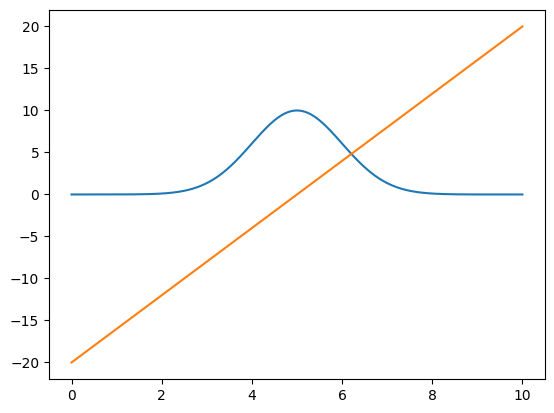

In [28]:
T_max = 10
times = np.linspace(0, T_max, 500)
sigma = 1
omega_max = 10
omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max/2) / sigma) ** 2)
delta_t = lambda t: 2*omega_max*(t / (T_max/2) - 1)

plt.plot(times, omega_t(times))
plt.plot(times, delta_t(times))

In [29]:
X = sigmax()
Z = sigmaz()
Y = sigmay()
I = qeye(2)

s1 = tensor(Z, Z, I)
s2 = tensor(I, Z, Z)
S = [s1, s2]
X_L = tensor(X, X, X)
Z_L = tensor(Z, Z, Z)

logical_zero = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
logical_one = X_L * logical_zero

state2 = tensor(basis(2, 0), basis(2, 0), basis(2, 1))
state3 = tensor(basis(2, 0), basis(2, 1), basis(2, 0))
state4 = tensor(basis(2, 0), basis(2, 1), basis(2, 1))
state5 = tensor(basis(2, 1), basis(2, 0), basis(2, 0))
state6 = tensor(basis(2, 1), basis(2, 0), basis(2, 1))
state7 = tensor(basis(2, 1), basis(2, 1), basis(2, 0))
hspace = [logical_zero, logical_one, state2, state3, state4, state5, state6, state7]

P0 = logical_zero * logical_zero.dag()
P1 = logical_one * logical_one.dag()
P2 = state2 * state2.dag()
P3 = state3 * state3.dag()
P4 = state4 * state4.dag()
P5 = state5 * state5.dag()
P6 = state6 * state6.dag()
P7 = state7 * state7.dag()
P = [P0, P1, P2, P3, P4, P5, P6, P7]

initial_state = logical_zero
n_qubits = 3

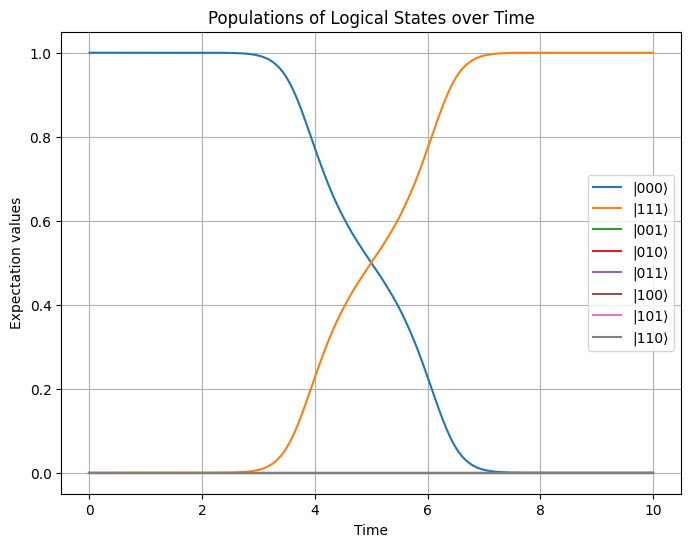

In [36]:
def hamiltonian(t, omega_max, T_max, sigma):
    omega_max = 10
    sigma = 1
    omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max/2) / sigma) ** 2)
    delta_t = lambda t: 2*omega_max*(t / (T_max/2) - 1)
    return omega_t(t) * X_L + delta_t(t) * Z_L

def evolve_system(initial_state, times, omega_max, T_max, sigma):
    H = lambda t: hamiltonian(t, omega_max, T_max, sigma)
    result = sesolve(H, initial_state, times, e_ops=P)
    return result


# Run evolution
T_max = 10
times = np.linspace(0, T_max, 500)
sigma = 1
omega_max = 10

result = evolve_system(initial_state, times, omega_max, T_max, sigma)

plt.figure(figsize=(8, 6))
for i, e in enumerate(result.expect):
    plt.plot(times, e, label=f'|{quantum_state_as_superposition(hspace[i]).split("|")[1]}')


plt.xlabel('Time')
plt.ylabel('Expectation values')
plt.title('Populations of Logical States over Time')
plt.legend()
plt.grid()
plt.show()

# Beacon Shor


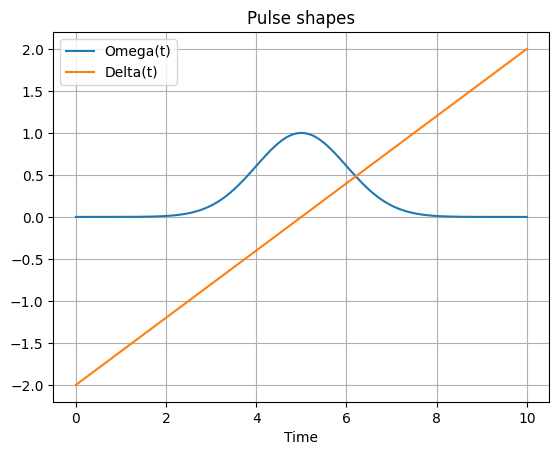

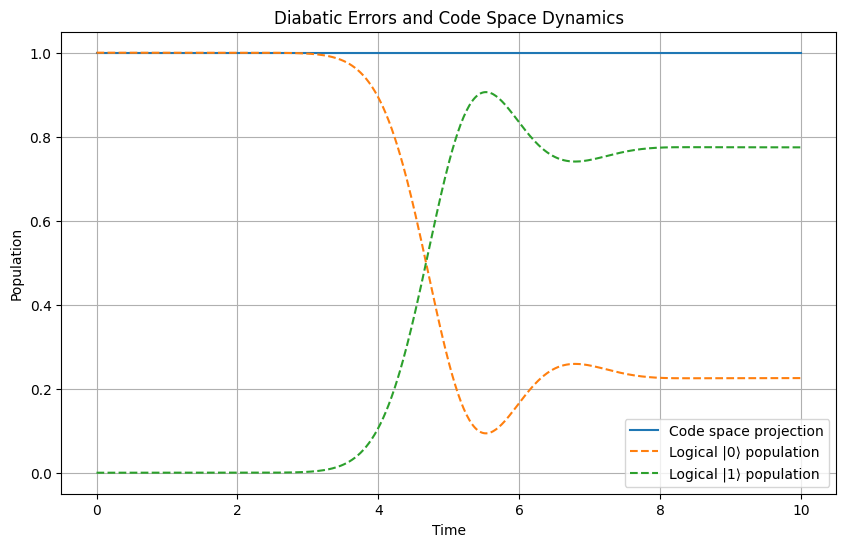

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm

# Parameters
T_max = 10
times = np.linspace(0, T_max, 500)
sigma = 1
omega_max = 1

# Pulses
omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max/2) / sigma) ** 2)
delta_t = lambda t: 2*omega_max*(t / (T_max/2) - 1)

plt.figure()
plt.plot(times, omega_t(times), label="Omega(t)")
plt.plot(times, delta_t(times), label="Delta(t)")
plt.legend()
plt.title("Pulse shapes")
plt.xlabel("Time")
plt.grid(True)
plt.show()

# Pauli Matrices
X, Y, Z, I = sigmax(), sigmay(), sigmaz(), qeye(2)
I4 = tensor(I, I, I, I)  # Identity for 4 qubits

# Stabilizers for Bacon-Shor code (4 qubits)
S_X = tensor(X, X, X, X)
S_Z = tensor(Z, Z, Z, Z)

# Logical operators (from provided encoding)
X_L = tensor(X, I, X, I)
Z_L = tensor(Z, Z, I, I)

# Logical states (provided by user)
logical_zero = (tensor(basis(2,0),basis(2,0),basis(2,0),basis(2,0)) +
                tensor(basis(2,1),basis(2,1),basis(2,1),basis(2,1))).unit()
logical_one = X_L * logical_zero

# Projector onto the code space (stabilizers +1 eigenspace)
P_code = (I4 + S_X)*(I4 + S_Z)/4

# Initial state
initial_state = logical_zero

# Hamiltonian definition
def hamiltonian(t):
    return omega_t(t) * X_L + delta_t(t) * Z_L

# Evolution function
def evolve_system(initial_state, times):
    H = hamiltonian
    result = sesolve(H, initial_state, times, e_ops=[P_code, logical_zero*logical_zero.dag(), logical_one*logical_one.dag()])
    return result

# Run evolution
result = evolve_system(initial_state, times)

# Plotting
plt.figure(figsize=(10,6))

# Probability in code space
plt.plot(times, np.real(result.expect[0]), label='Code space projection')

# Population of logical zero and logical one
plt.plot(times, np.real(result.expect[1]), '--', label='Logical |0⟩ population')
plt.plot(times, np.real(result.expect[2]), '--', label='Logical |1⟩ population')

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Diabatic Errors and Code Space Dynamics')
plt.legend()
plt.grid()
plt.show()


0.0
1.0
0.0
1.0


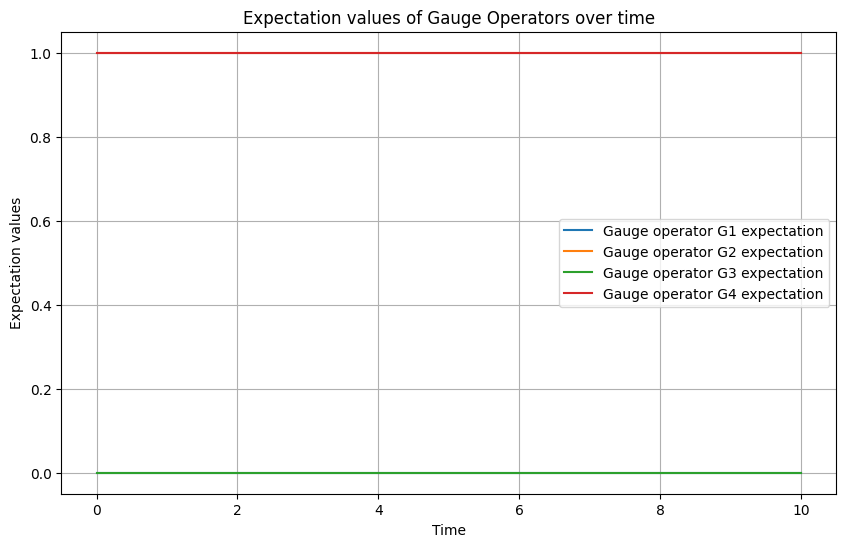

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Parameters
T_max = 10
times = np.linspace(0, T_max, 500)
sigma = 1
omega_max = 10

# Pulses
omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max/2) / sigma) ** 2)
delta_t = lambda t: 2 * omega_max * (t / (T_max / 2) - 1)

# Pauli Matrices
X, Z, I = sigmax(), sigmaz(), qeye(2)
I4 = tensor(I, I, I, I)  # Identity for 4 qubits

# Gauge operators for Bacon-Shor code
G = [
    tensor(X, X, I, I),
    tensor(Z, I, Z, I),
    tensor(I, I, X, X),
    tensor(I, Z, I, Z)
]

# Logical operators
X_L = tensor(X, I, X, I)
Z_L = tensor(Z, Z, I, I)

# Logical states
logical_zero = (tensor(basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0)) +
                tensor(basis(2, 1), basis(2, 1), basis(2, 1), basis(2, 1))).unit()
logical_one = X_L * logical_zero

# Initial state
initial_state = logical_zero

# Hamiltonian definition
def hamiltonian(t):
    return omega_t(t) * X_L + delta_t(t) * Z_L

# Evolution function
def evolve_system(initial_state, times):
    H = hamiltonian
    result = sesolve(H, initial_state, times, e_ops=G)
    return result

# Run evolution
result = evolve_system(initial_state, times)

# Plotting expectation values of gauge operators
plt.figure(figsize=(10, 6))
for i, g_expect in enumerate(result.expect):
    print(np.sum(np.real(g_expect))/ len(g_expect))
    plt.plot(times, np.real(g_expect), label=f'Gauge operator G{i+1} expectation')

plt.xlabel('Time')
plt.ylabel('Expectation values')
plt.title('Expectation values of Gauge Operators over time')
plt.legend()
plt.grid()
plt.show()

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   7.77s


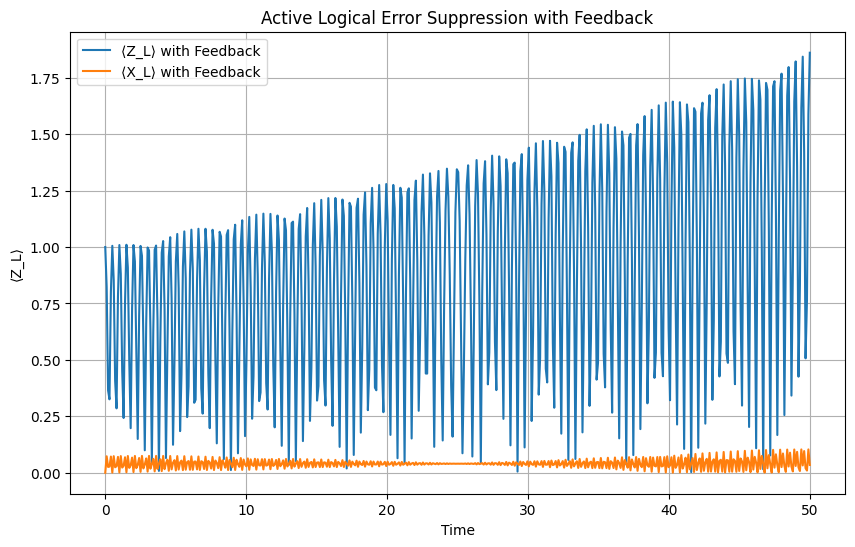

In [161]:
T_max = 50
times = np.linspace(0, T_max, 500)
sigma = 1
omega_max = 1
measurement_strength = 1.0  # Measurement strength γ

# Pulses (Diabatic errors)
omega_t = lambda t: omega_max * np.exp(-0.5*((t - T_max/2)/sigma)**2)
delta_t = lambda t: 2*omega_max*(t/(T_max/2)-1)


# Logical operators and stabilizers
S_X = tensor(X, X, X, X)
S_Z = tensor(Z, Z, Z, Z)
X_L = tensor(X, I, X, I)
Z_L = tensor(Z, Z, I, I)

# Logical states
logical_zero = (tensor(basis(2,0),basis(2,0),basis(2,0),basis(2,0)) +
                tensor(basis(2,1),basis(2,1),basis(2,1),basis(2,1))).unit()

initial_state = logical_zero

# Logical measurement operator (weak measurement of Z_L)
# c_op = [np.sqrt(measurement_strength) * Z_L]
# Define single-qubit raising and lowering operators
sigma_plus = create(2)  # σ+
sigma_minus = destroy(2)  # σ-

# Define collapse operators for each qubit in the 4-qubit Hilbert space
rate = 1e-4  # Measurement strength
c_ops = [rate*i for i in [
    tensor(sigma_minus, I, I, I),  # σ- on qubit 1
    tensor(I, sigma_minus, I, I),  # σ- on qubit 2
    tensor(I, I, sigma_minus, I),  # σ- on qubit 3
    tensor(I, I, I, sigma_minus),  # σ- on qubit 4
    tensor(sigma_plus, I, I, I),   # σ+ on qubit 1
    tensor(I, sigma_plus, I, I),   # σ+ on qubit 2
    tensor(I, I, sigma_plus, I),   # σ+ on qubit 3
    tensor(I, I, I, sigma_plus)    # σ+ on qubit 4
]]


# Hamiltonian without feedback
def H_sys(t, args):
    return omega_t(t)*X_L + delta_t(t)*Z_L

# Feedback control Hamiltonian
feedback_strength = 50  # Strength of feedback Hamiltonian

def H_feedback(t, args, rho):
    expectation_ZL = expect(Z_L, rho)
    correction = -feedback_strength * expectation_ZL  # Negative feedback
    return correction * X_L

# Wrap H_feedback to match the expected signature
def H_feedback_wrapper(t, args):
    rho = args['rho']
    return H_feedback(t, args, rho)

# Total Hamiltonian with feedback
H = [H_sys, H_feedback_wrapper]

e_ops = [Z_L, X_L]
# Run stochastic master equation solver (smesolve)
result = smesolve(H, initial_state, times, c_ops, e_ops=e_ops, ntraj=1, args={'rho': initial_state}, progress_bar=True)

# Plot logical observable expectation value
plt.figure(figsize=(10, 6))
plt.plot(times, np.abs(result.expect[0]), label="⟨Z_L⟩ with Feedback")
plt.plot(times, np.abs(result.expect[1]), label="⟨X_L⟩ with Feedback")
plt.xlabel("Time")
plt.ylabel("⟨Z_L⟩")
plt.title("Active Logical Error Suppression with Feedback")
plt.grid(True)
plt.legend()
plt.show()

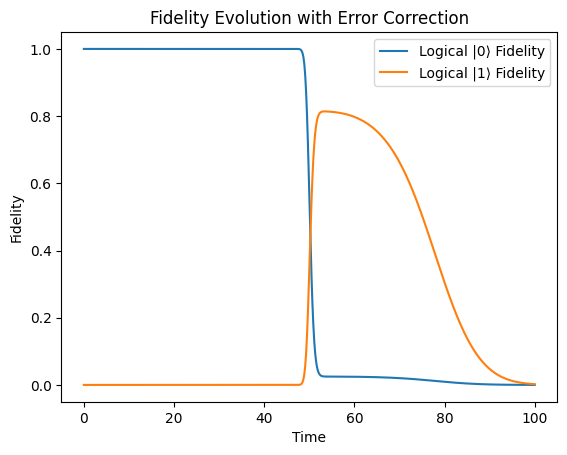

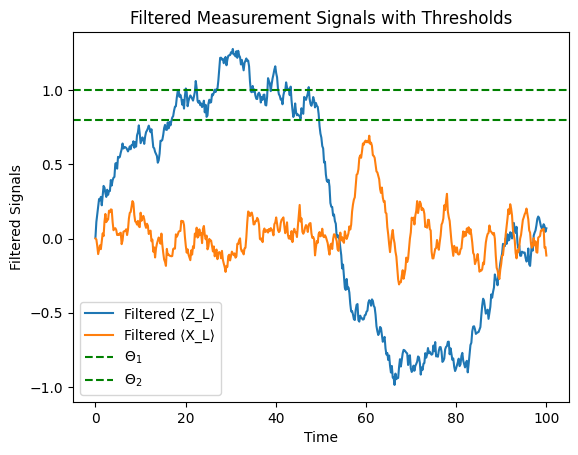

In [172]:
T_max = 10
tlist = np.linspace(0, T_max, 500)

# Initialize filtered measurement signals
I_ZL_bar, I_XL_bar = 0.0, 0.0

# Record fidelity
fidelities_0 = []
fidelities_1 = []
errors = []

I_ZLs = []
I_XLs = []

# Parameters
gamma_m = 1               # measurement strength

gamma = 1.25e-9 * gamma_m # bit flip error rate
eta = 1                   # quantum efficiency (1 for ideal detectors)
tau = 2.5 / gamma_m       # measurement time parameter
dt = 0.1 / gamma_m        # time step
alpha = dt / tau
theta1 = 1  # threshold for Z_L
theta2 = 0.8  # threshold for X_L
zero = logical_zero
one = logical_one

rho = ket2dm(zero)

# Time evolution loop
for t in tlist:
    # Hamiltonian for rapid adiabatic passage
    H = omega_t(t) * X_L + delta_t(t) * Z_L

    # Effective SME step
    dW_ZL, dW_XL = np.random.normal(scale=np.sqrt(dt), size=2)

    meas_ZL = np.sqrt(2 * gamma_m * eta) * (Z_L * rho + rho * Z_L - 2 * expect(Z_L, rho) * rho)
    meas_XL = np.sqrt(2 * gamma_m * eta) * (X_L * rho + rho * X_L - 2 * expect(X_L, rho) * rho)

    drho = -1j * (H * rho - rho * H)
    # for c in c_ops:
    #     drho += c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c)
        
    # drho += gamma_m * (Z_L * rho * Z_L - 0.5 * (Z_L**2 * rho + rho * Z_L**2))
    # drho += gamma_m * (X_L * rho * X_L - 0.5 * (X_L**2 * rho + rho * X_L**2))
    
    # drho += meas_ZL * dW_ZL + meas_XL * dW_XL

    rho = (rho + dt * drho).unit()

    # Measurement currents (with noise)
    I_ZL = expect(Z_L, rho) + dW_ZL / np.sqrt(dt)
    I_XL = expect(X_L, rho) + dW_XL / np.sqrt(dt)

    # Exponential filtering
    I_ZL_bar = (1 - alpha) * I_ZL_bar + alpha * I_ZL
    I_XL_bar = (1 - alpha) * I_XL_bar + alpha * I_XL
    
    I_ZLs.append(I_ZL_bar)
    I_XLs.append(I_XL_bar)
    
    # # Double threshold logic
    # if I_ZL_bar < theta1 and I_XL_bar > theta2:
    #     rho = X_L * rho * X_L
    #     I_ZL_bar, I_XL_bar = 1, 1
    #     errors.append(("X_L", t))
    # elif I_ZL_bar > theta2 and I_XL_bar < theta1:
    #     rho = Z_L * rho * Z_L
    #     I_ZL_bar, I_XL_bar = 1, 1
    #     errors.append(("Z_L", t))
    
    # Record fidelities
    fidelities_0.append(np.abs(zero.dag() * rho * zero))
    fidelities_1.append(np.abs(one.dag() * rho * one))

# Plot results
plt.plot(tlist, fidelities_0, label='Logical |0⟩ Fidelity')
plt.plot(tlist, fidelities_1, label='Logical |1⟩ Fidelity')
# for e in errors:
    # plt.axvline(x=e[1], color='red', linestyle='--', label=f"Error: {e[0]}")
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity Evolution with Error Correction")
plt.legend()
plt.show()

plt.plot(tlist, I_ZLs, label='Filtered ⟨Z_L⟩')
plt.plot(tlist, I_XLs, label='Filtered ⟨X_L⟩')
plt.axhline(theta1, color='green', linestyle='--', label=r'$\Theta_1$')
plt.axhline(theta2, color='green', linestyle='--', label=r'$\Theta_2$')
# for e in errors:
#     plt.axvline(x=e[1], color='red', linestyle='--', label=f"Error: {e[0]}")
plt.xlabel("Time")
plt.ylabel("Filtered Signals")
plt.title("Filtered Measurement Signals with Thresholds")
plt.legend()
plt.show()

  0%|          | 0/499 [00:00<?, ?it/s]

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:

 18%|█▊        | 92/499 [00:00<00:00, 916.49it/s]

Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. E

 37%|███▋      | 184/499 [00:00<00:00, 904.05it/s]

Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. E

 55%|█████▌    | 275/499 [00:00<00:00, 897.29it/s]


100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00

 73%|███████▎  | 365/499 [00:00<00:00, 806.14it/s]


100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00

 91%|█████████ | 454/499 [00:00<00:00, 831.02it/s]

Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
100.0%. Run time:   0.00s. E

100%|██████████| 499/499 [00:00<00:00, 848.15it/s]

Total run time:   0.00s


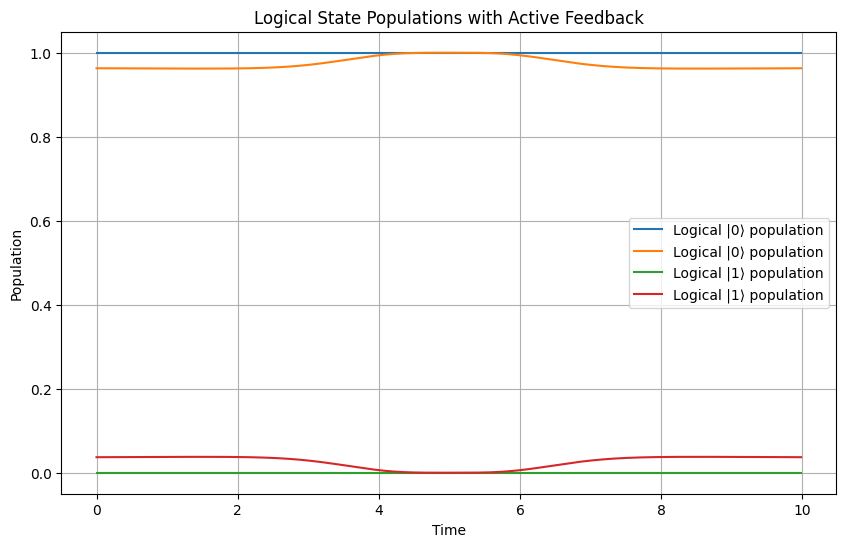

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm

# Parameters
T_max = 10
times = np.linspace(0, T_max, 500)
sigma = 1
omega_max = 10
measurement_strength = 1.0
feedback_strength = 5

# Pulses
omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max / 2) / sigma) ** 2)
delta_t = lambda t: 2 * omega_max * (t / (T_max / 2) - 1)

# Operators
X, Z, I = sigmax(), sigmaz(), qeye(2)
X_L = tensor(X, I, X, I)
Z_L = tensor(Z, Z, I, I)

# Logical states
logical_zero = (tensor(basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0)) +
                tensor(basis(2, 1), basis(2, 1), basis(2, 1), basis(2, 1))).unit()
logical_one = X_L * logical_zero

# Measurement operator
c_ops = [np.sqrt(measurement_strength) * Z_L]

# Observables
e_ops = [logical_zero * logical_zero.dag(), logical_one * logical_one.dag()]

# Initialize state
state = logical_zero
expectations = []

# Time evolution loop
for t in tqdm(times[:-1]):
    # System Hamiltonian
    H_sys = omega_t(t) * X_L + delta_t(t) * Z_L

    # Feedback Hamiltonian
    expectation_ZL = expect(Z_L, state)
    H_feedback = -feedback_strength * expectation_ZL * X_L

    # Total Hamiltonian
    H = H_sys + H_feedback

    # Solve for the next state
    result = smesolve(H, state, [t, t + (times[1] - times[0])], c_ops, e_ops=e_ops, ntraj=1)
    
    # Update state using expectation values
    state = result.states[-1] if result.states else state

    # Store expectations
    expectations.append([np.real(exp) for exp in result.expect])

# Convert expectations to array
expectations = np.array(expectations)

# Plot logical state populations
plt.figure(figsize=(10, 6))
plt.plot(times[:-1], expectations[:, 0], label="Logical |0⟩ population")
plt.plot(times[:-1], expectations[:, 1], label="Logical |1⟩ population")
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Logical State Populations with Active Feedback")
plt.legend()
plt.grid(True)
plt.show()

# Active Feedback Control for Diabatic Errors

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm

In [2]:
def op_on_qubit(op, i, N=3):
    return tensor([op if k == i else I for k in range(N)])

In [4]:
# Pauli Matrices
X, Y, Z, I = sigmax(), sigmay(), sigmaz(), qeye(2)
I4 = tensor(I, I, I, I)  # Identity for 4 qubits

# Pauli operators on 3 qubits
X1, X2, X3 = [op_on_qubit(X, i) for i in range(3)]
Z1, Z2, Z3 = [op_on_qubit(Z, i) for i in range(3)]

# Stabilizers
S1 = Z1 * Z2
S2 = Z2 * Z3

# Initial state: logical |0_L> = |000>
psi0 = tensor(basis(2,0), basis(2,0), basis(2,0))
rho = ket2dm(psi0)

# Target logical states for fidelity
zero = tensor(basis(2,0), basis(2,0), basis(2,0))
one  = tensor(basis(2,1), basis(2,1), basis(2,1))

state3 = tensor(basis(2,0), basis(2,0), basis(2,1))
state4 = tensor(basis(2,0), basis(2,1), basis(2,0))
state5 = tensor(basis(2,0), basis(2,1), basis(2,1))
state6 = tensor(basis(2,1), basis(2,0), basis(2,0))
state7 = tensor(basis(2,1), basis(2,0), basis(2,1))
state8 = tensor(basis(2,1), basis(2,1), basis(2,0))



In [23]:
# Parameters
gamma_m = 1.0  # Measurement strength
T_max = 50 / gamma_m
dt = 0.01*gamma_m  # Time step for numerical integration
times =  np.arange(0, T_max, dt)
sigma = 50 / gamma_m      # pulse width
omega_max = 0.1

measurement_strength = 1.0
feedback_strength = 5

# Pulses
omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max / 2) / sigma) ** 2)
delta_t = lambda t: 4 * omega_max * (t / (T_max / 2) - 1)

# Operators
X, Z, I = sigmax(), sigmaz(), qeye(2)
X_L = X1 * X2 * X3
Z_L = (Z1 + Z2 + Z3) / 3

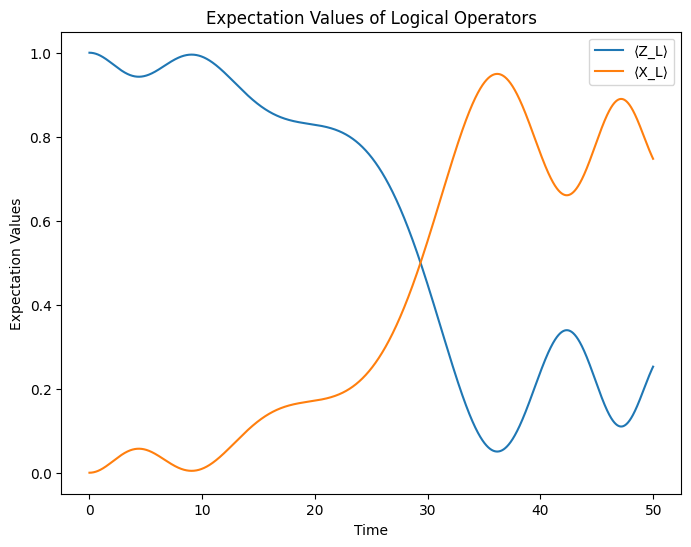

In [24]:
P0 = zero * zero.dag()
P1 = one * one.dag()
H = [[X_L, omega_t], [Z_L, delta_t]]
results = sesolve(H,
    psi0=zero,
    tlist=times,
    e_ops=[P0, P1]
)
# plot fidelities 
plt.figure(figsize=(8, 6))
plt.plot(times, np.abs(results.expect[0]), label="⟨Z_L⟩")
plt.plot(times, np.abs(results.expect[1]), label="⟨X_L⟩")
plt.xlabel("Time")
plt.ylabel("Expectation Values")
plt.title("Expectation Values of Logical Operators")
plt.legend()
plt.show()

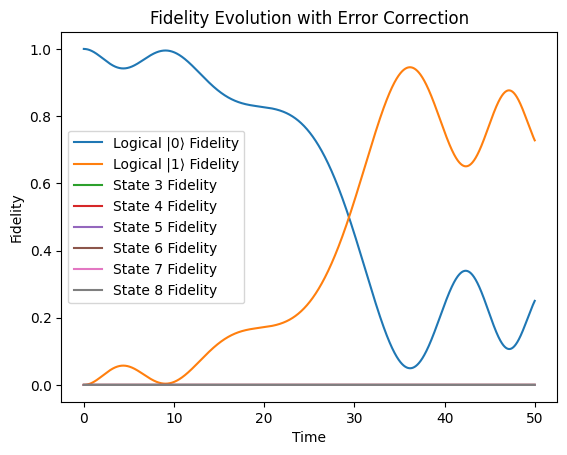

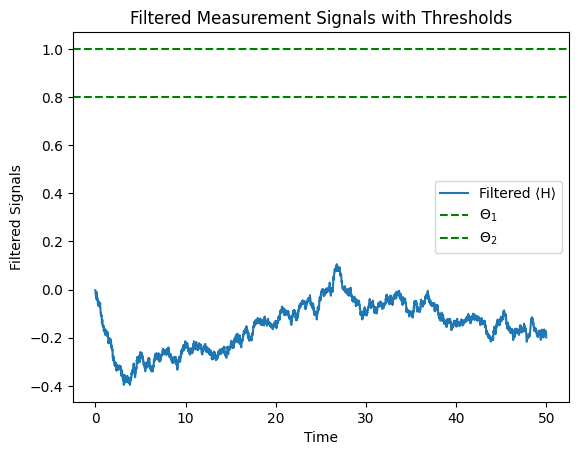

In [25]:
# Initialize filtered measurement signals
I_ZL_bar, I_XL_bar, I_H_bar = 0.0, 0.0, 0.0

# Record fidelity
fidelities_0 = []
fidelities_1 = []
fidelities_2 = []
fidelities_3 = []
fidelities_4 = []
fidelities_5 = []
fidelities_6 = []
fidelities_7 = []
errors = []

sigma_minus = sigmam()
sigma_plus = sigmap()

# rate = 1e-2  # Measurement strength
#
# c_ops = [rate*i for i in [
#     tensor(sigma_minus, I, I),  # σ- on qubit 1
#     tensor(I, sigma_minus, I),  # σ- on qubit 2
#     tensor(I, I, sigma_minus),  # σ- on qubit 3
#
#     tensor(sigma_plus, I, I),   # σ+ on qubit 1
#     tensor(I, sigma_plus, I),   # σ+ on qubit 2
#     tensor(I, I, sigma_plus)   # σ+ on qubit 3
# ]]

I_ZLs = []
I_XLs = []
I_Hs = []

# Parameters
gamma = 1.25e-9 * gamma_m # bit flip error rate
eta = 1                   # quantum efficiency (1 for ideal detectors)
tau = 2 / gamma_m       # measurement time parameter
alpha = dt / tau
theta1 = 1  # threshold for Z_L
theta2 = 0.8  # threshold for X_L

rho = ket2dm(zero)

# Time evolution loop
for t in times:
    # Hamiltonian for rapid adiabatic passage
    H = omega_t(t) * X_L + delta_t(t) * Z_L
    
    # Effective SME step
    dW_ZL, dW_XL, dW_H = np.random.normal(scale=np.sqrt(dt), size=3)

    # meas_ZL = np.sqrt(2 * gamma_m * eta) * (Z_L * rho + rho * Z_L - 2 * expect(Z_L, rho) * rho)
    # meas_XL = np.sqrt(2 * gamma_m * eta) * (X_L * rho + rho * X_L - 2 * expect(X_L, rho) * rho)
    meas_H = np.sqrt(2 * gamma_m * eta) * (H * rho + rho * H - 2 * expect(H, rho) * rho)

    drho = -1j * (H * rho - rho * H)
    # for c in c_ops:
    #     drho += c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c)
    #
    # drho += gamma_m * (Z_L * rho * Z_L - 0.5 * (Z_L**2 * rho + rho * Z_L**2))
    # drho += gamma_m * (X_L * rho * X_L - 0.5 * (X_L**2 * rho + rho * X_L**2))
    
    # drho += meas_ZL * dW_ZL + meas_XL * dW_XL

    rho = (rho + dt * drho).unit()

    # Measurement currents (with noise)
    # I_ZL = expect(Z_L, rho) + dW_ZL / np.sqrt(dt)
    # I_XL = expect(X_L, rho) + dW_XL / np.sqrt(dt)
    I_H = expect(H, rho) + dW_H / np.sqrt(dt)

    # Exponential filtering
    # I_ZL_bar = (1 - alpha) * I_ZL_bar + alpha * I_ZL
    # I_XL_bar = (1 - alpha) * I_XL_bar + alpha * I_XL
    I_H_bar = (1 - alpha) * I_H_bar + alpha * I_H


    # I_ZLs.append(I_ZL_bar)
    # I_XLs.append(I_XL_bar)
    I_Hs.append(I_H_bar)
    
    # # Double threshold logic
    # if I_ZL_bar < theta1 and I_XL_bar > theta2:
    #     rho = X_L * rho * X_L
    #     I_ZL_bar, I_XL_bar = 1, 1
    #     errors.append(("X_L", t))
    # elif I_ZL_bar > theta2 and I_XL_bar < theta1:
    #     rho = Z_L * rho * Z_L
    #     I_ZL_bar, I_XL_bar = 1, 1
    #     errors.append(("Z_L", t))
    
    # Record fidelities
    fidelities_0.append(zero.dag() * rho * zero)
    fidelities_1.append(one.dag() * rho * one)
    fidelities_2.append(state3.dag() * rho * state3)
    fidelities_3.append(state4.dag() * rho * state4)
    fidelities_4.append(state5.dag() * rho * state5)
    fidelities_5.append(state6.dag() * rho * state6)
    fidelities_6.append(state7.dag() * rho * state7)
    fidelities_7.append(state8.dag() * rho * state8)
    

# Plot results
plt.plot(times, fidelities_0, label='Logical |0⟩ Fidelity')
plt.plot(times, fidelities_1, label='Logical |1⟩ Fidelity')
plt.plot(times, fidelities_2, label='State 3 Fidelity')
plt.plot(times, fidelities_3, label='State 4 Fidelity')
plt.plot(times, fidelities_4, label='State 5 Fidelity')
plt.plot(times, fidelities_5, label='State 6 Fidelity')
plt.plot(times, fidelities_6, label='State 7 Fidelity')
plt.plot(times, fidelities_7, label='State 8 Fidelity')

# for e in errors:
    # plt.axvline(x=e[1], color='red', linestyle='--', label=f"Error: {e[0]}")
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity Evolution with Error Correction")
plt.legend()
plt.show()

# plt.plot(times, I_ZLs, label='Filtered ⟨Z_L⟩')
# plt.plot(times, I_XLs, label='Filtered ⟨X_L⟩')
plt.plot(times, I_Hs, label='Filtered ⟨H⟩')
plt.axhline(theta1, color='green', linestyle='--', label=r'$\Theta_1$')
plt.axhline(theta2, color='green', linestyle='--', label=r'$\Theta_2$')
# for e in errors:
#     plt.axvline(x=e[1], color='red', linestyle='--', label=f"Error: {e[0]}")
plt.xlabel("Time")
plt.ylabel("Filtered Signals")
plt.title("Filtered Measurement Signals with Thresholds")
plt.legend()
plt.show()